In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, filtfilt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

from torcheeg.models import EEGNet

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

## Reading Data

The following cell reads the data and places it in a dictionary formatted to:
```
{
    sub_id: {
        run_id: {
            "eeg": [],
            "aux": [],
            "label": []
        }
    }
}
```

In [2]:
def bandpass_filter(data, lowcut=7, highcut=30, fs=250, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=1) 

In [3]:
# data loading
eeg_dir = "data/data/misc/"
label_dir = "data/data/label/"

data = {}

# reading data
for sub_id in os.listdir(eeg_dir):
    data[sub_id] = {}

    dir_path = os.path.join(eeg_dir, sub_id) 
    for run_id in os.listdir(dir_path):

        # ignoring corrupt data
        if run_id == "run_34":
            continue

        if sub_id == "sub_1":
            if run_id in ["run_1", "run_3"]:
                continue

        if sub_id == "sub_2":
            if run_id in ["run_2"]:
                continue

        if sub_id == "sub_3":
            if run_id in ["run_2", "run_5"]:
                continue


        # getting run number
        i = int(run_id.replace("run_", ""))

        # getting path for aux and eeg
        base_path = os.path.join(dir_path, run_id)
        eeg_path = os.path.join(base_path, f"eeg_run-{i}.npy")
        aux_path = os.path.join(base_path, f"aux_run-{i}.npy")

        # getting path for label
        base_path_label = os.path.join(label_dir, sub_id)
        base_path_label = os.path.join(base_path_label, run_id)

        
        label_path = os.path.join(base_path_label, "labels.npy")

        filtered_eeg = bandpass_filter(np.load(eeg_path))
        
        data[sub_id][run_id] = {
            "eeg": np.load(eeg_path),
            "filtered_eeg": filtered_eeg,
            "aux": np.load(aux_path),
            "label": np.load(label_path)
        }        

## Data Visualization

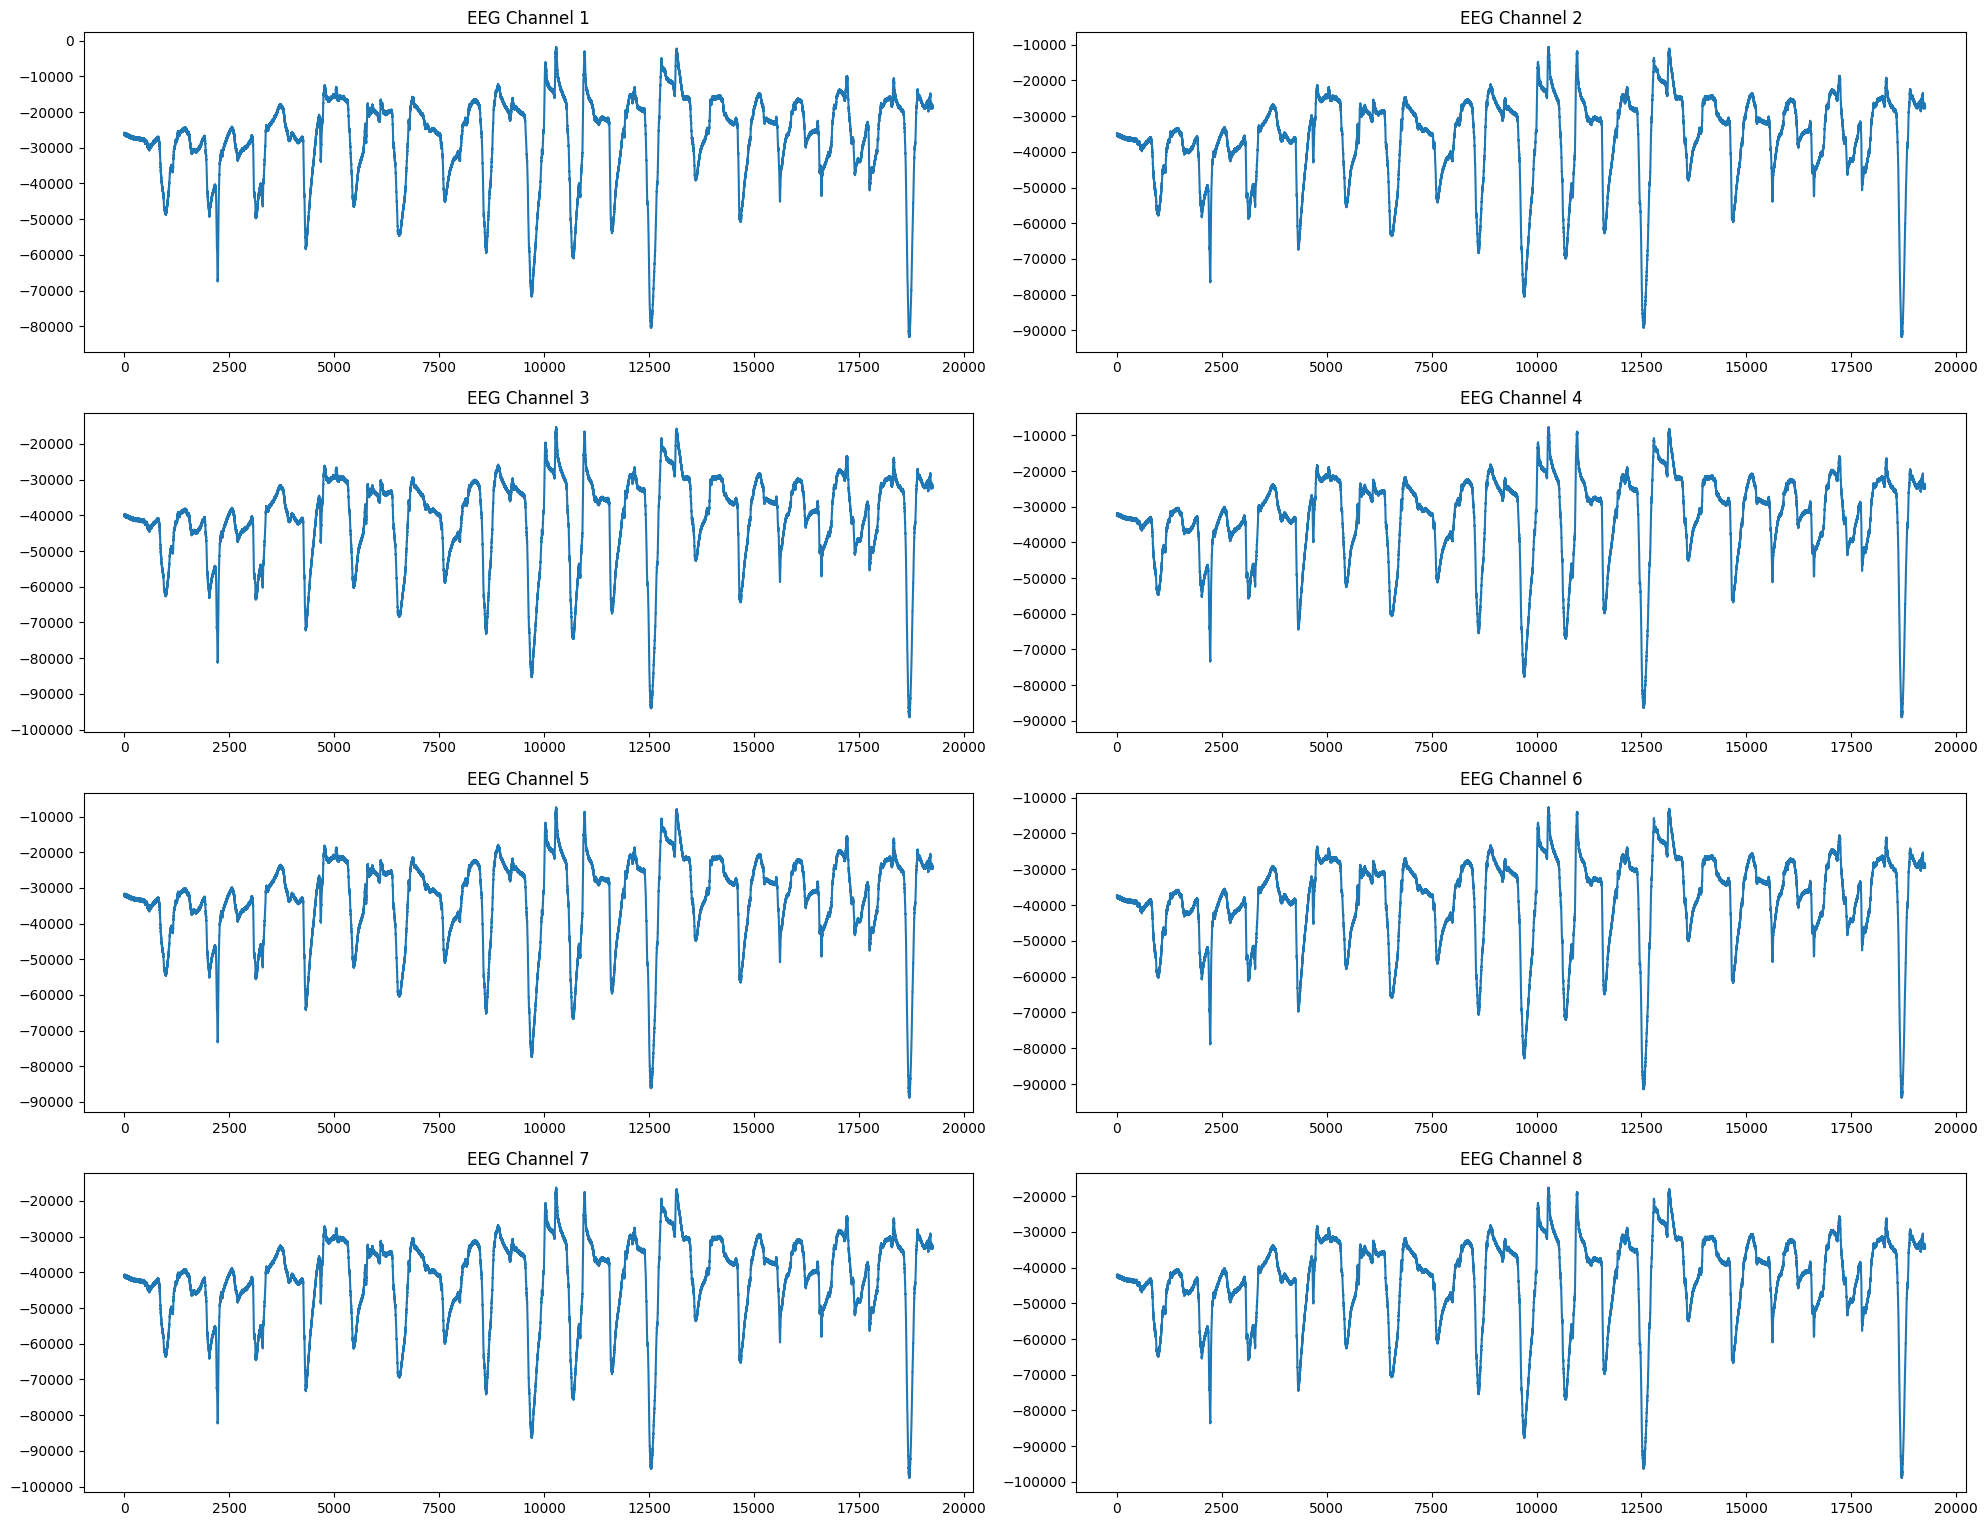

In [4]:
sub_id = "sub_2"
run_id = "run_1"
ignore = 100

eeg_data = data[sub_id][run_id]["eeg"]

# Create subplots
fig, axes = plt.subplots(4, 2, figsize=(20, 16))

for i, ax in enumerate(axes.flatten()):
    ax.plot(np.arange(len(eeg_data[i][ignore:])), eeg_data[i][ignore:])
    ax.set_title(f"EEG Channel {i+1}")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

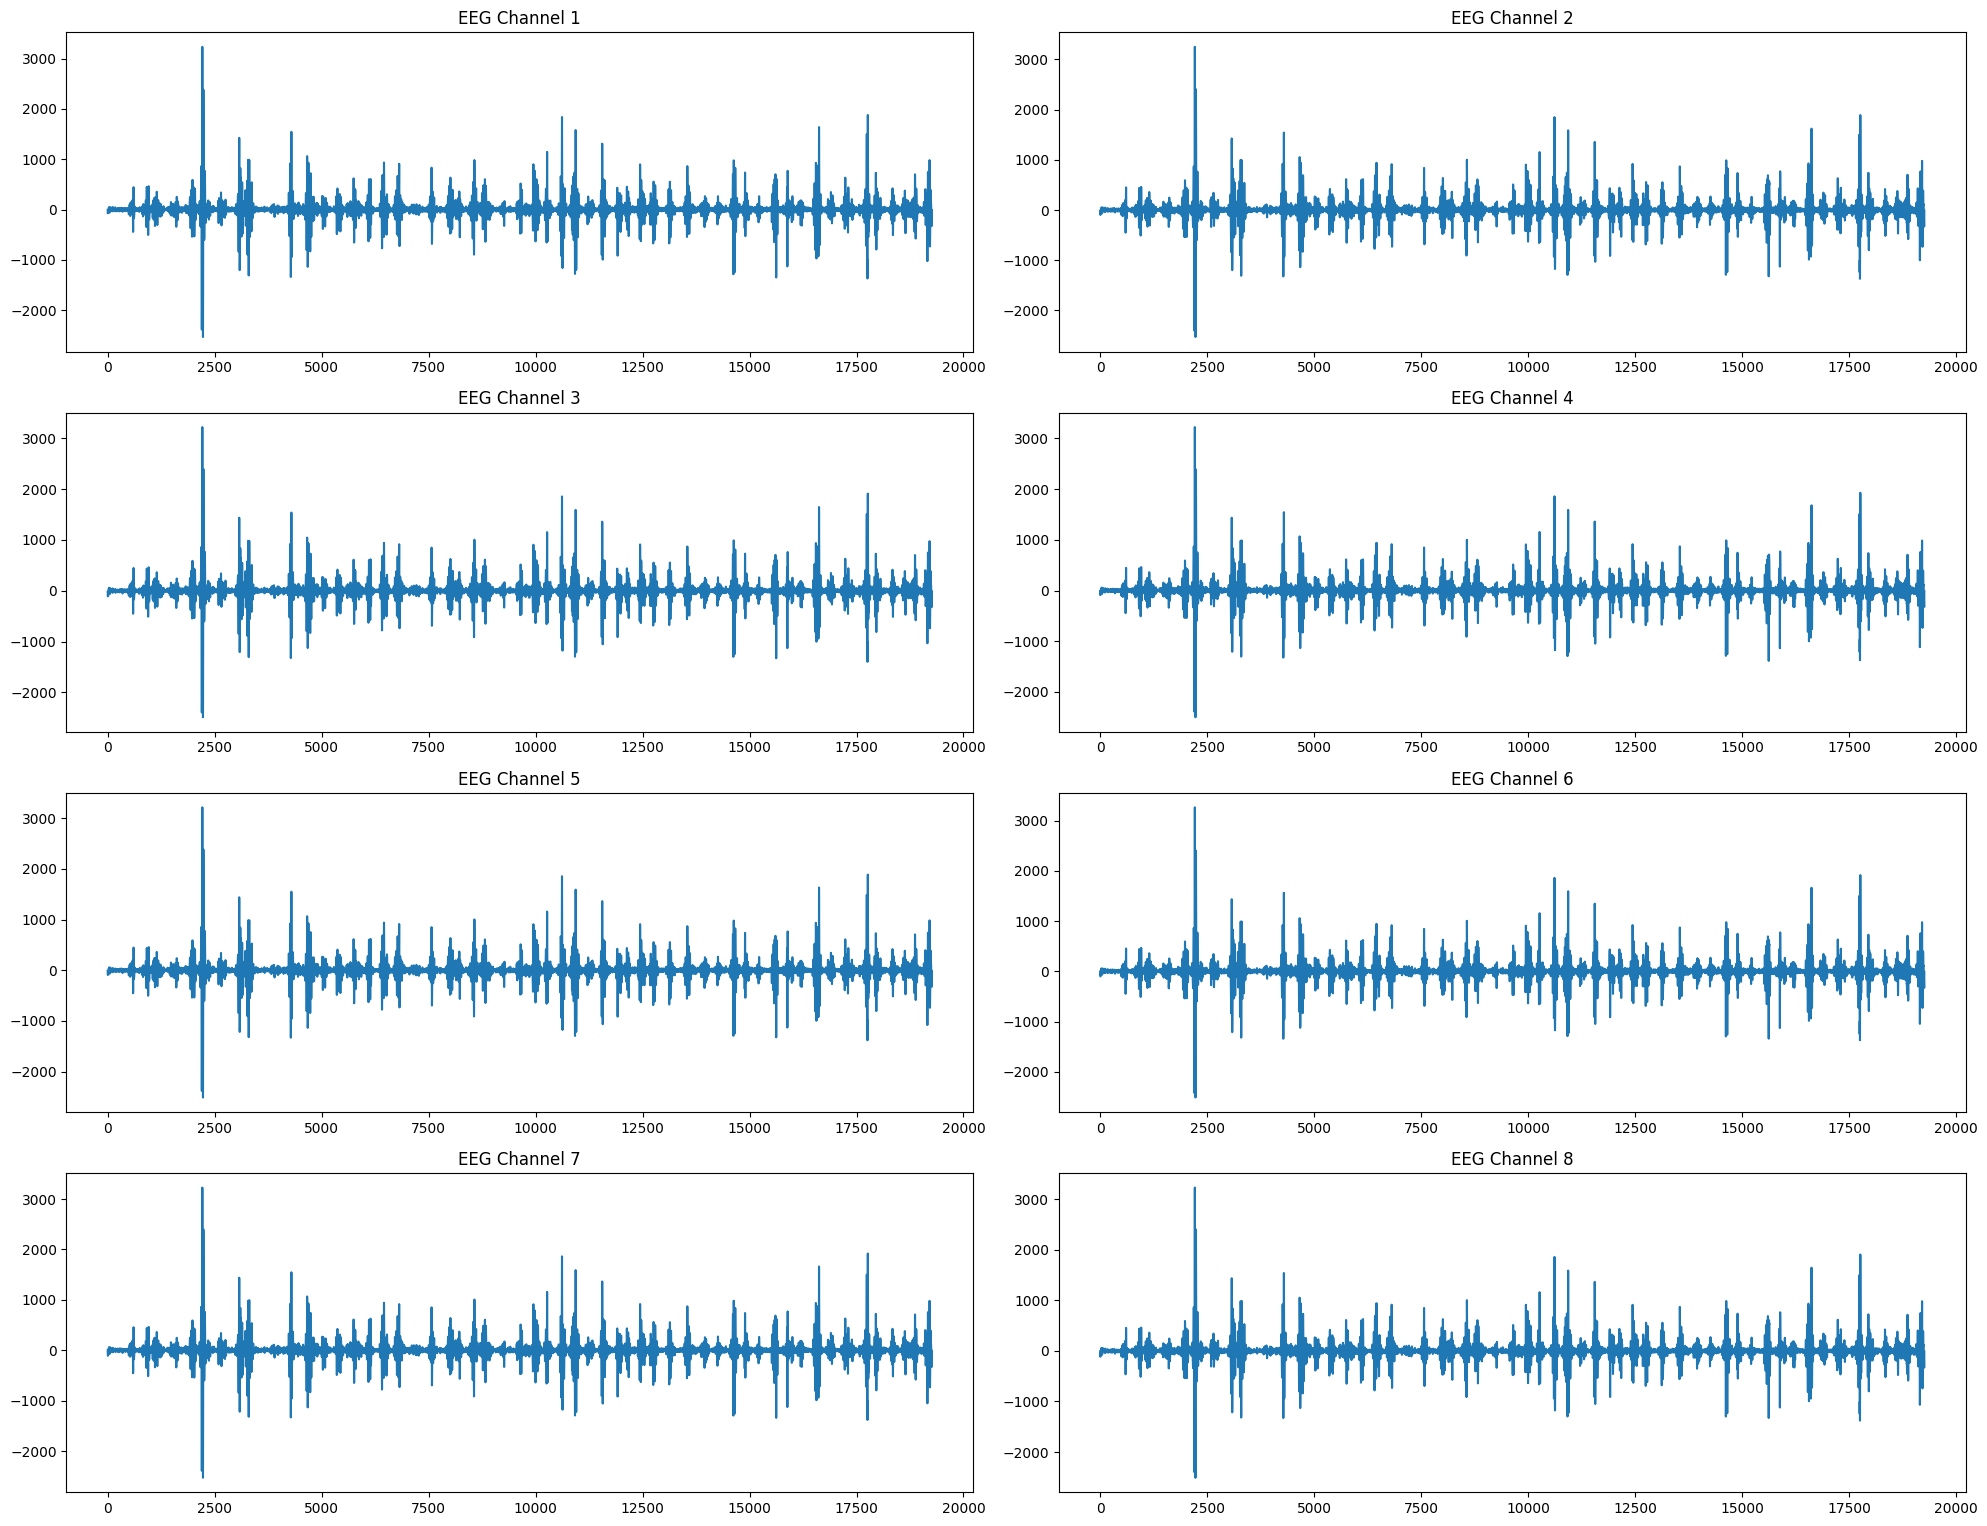

In [5]:
eeg_data = data[sub_id][run_id]["filtered_eeg"]

# Create subplots
fig, axes = plt.subplots(4, 2, figsize=(20, 16))

for i, ax in enumerate(axes.flatten()):
    ax.plot(np.arange(len(eeg_data[i][ignore:])), eeg_data[i][ignore:])
    ax.set_title(f"EEG Channel {i+1}")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

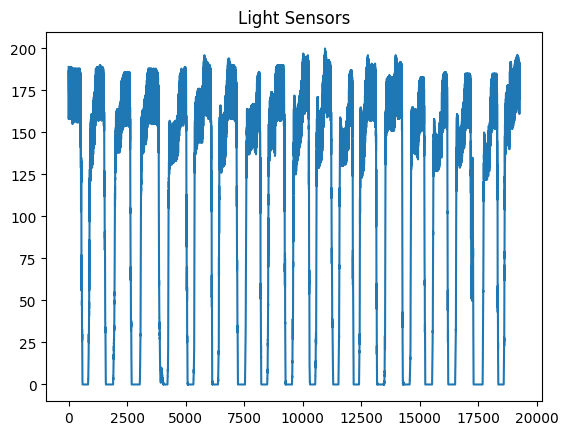

In [6]:
ignore = 100

aux_data = data[sub_id][run_id]["aux"][1]

plt.plot(np.arange(len(aux_data[ignore:])), aux_data[ignore:])
plt.title(f"Light Sensors")
plt.show()

## Cleaning the data

In [7]:
ignore = 100
pre_onset_window = 200
sample_window = 300 + pre_onset_window
cleaned_data = {}

for sub_id in list(data.keys()):
    eeg_window = []
    labels = []
    
    for run_id in list(data[sub_id].keys()):
        aux_data = data[sub_id][run_id]["aux"][1][ignore:]
        eeg_data = data[sub_id][run_id]["filtered_eeg"][:, ignore:]
        label_data = data[sub_id][run_id]["label"]
    
        labels.append(label_data)
    
        window_mask = aux_data > 10
        prev = False
        window = []
        for i, mask in enumerate(window_mask):
            if mask:
                if len(window) == 0:
                    for j in range(i-pre_onset_window, i):
                        window.append(eeg_data[:, j])
                
                window.append(eeg_data[:, i])
        
            if prev and not mask and len(window) > (100 + pre_onset_window):
                eeg_window.append(np.asarray(window))
                window = []
                
            prev = mask

    labels = np.asarray(labels).flatten()

    # asserting if data is valid
    print(len(eeg_window), len(labels))
    assert len(eeg_window) == len(labels)

    # First, split into train (70%) and temp (30%)
    eeg_train, eeg_temp, label_train, label_temp = train_test_split(
        eeg_window, labels, test_size=0.4, stratify=labels, random_state=3
    )
    
    # Split temp into validation (50%) and test (50%) ensuring stratification
    eeg_val, eeg_test, label_val, label_test = train_test_split(
        eeg_temp, label_temp, test_size=0.5, stratify=label_temp, random_state=3
    )
    
    # Store in dictionary
    cleaned_data[sub_id] = {
        "train": {"eeg": eeg_train, "label": label_train},
        "val": {"eeg": eeg_val, "label": label_val},
        "test": {"eeg": eeg_test, "label": label_test}
    }

54 54
72 72
54 54
90 90
90 90


## Dataloader

In [8]:
class Dataset(Dataset):
    def __init__(self, data: dict, mode: str, sample_window=150):
        """
        Args:
            data: (dict) cleaned data with {eeg: [c, t], label: [t]} where
                        c is channels, and t is time
            mode: (str) one of ["hand", "rps", "both"]
        """
        if mode not in ["hand", "rps", "both"]:
            raise Exception("Not a valid mode, choose one of ['hand', 'rps', 'both']")

        self.mode = mode
        self.eeg_data = data["eeg"]
        self.sample_window = sample_window
        
        if self.mode == "hand":
            self.num_classes = 2
            self.labels = []

            for l in data["label"]:
                if "right" in l:
                    self.labels.append(0)

                elif "left" in l:
                    self.labels.append(1)

                else:
                    raise Exception("incorrect label")

        elif self.mode == "rps":
            self.num_classes = 3
            self.labels = []

            for l in data["label"]:
                if "rock" in l:
                    self.labels.append(0)

                elif "paper" in l:
                    self.labels.append(1)

                elif "scissor" in l:
                    self.labels.append(2)

                else:
                    raise Exception("incorrect label")

        else:
            self.num_classes = 6
            self.labels = []
            
            mapping = {
                "left_rock": 0, 
                "left_paper": 1, 
                "left_scissors": 2, 
                "right_rock": 3, 
                "right_paper": 4, 
                "right_scissors": 5
            }
            
            for l in data["label"]:
                if l not in list(mapping.keys()):
                    raise Exception("incorrect label")

                self.labels.append(mapping[l])


    def __len__(self):
        return len(eeg_data)

    def __getitem__(self, idx):
        eeg = self.eeg_data[idx].transpose()[:, :self.sample_window]
        label = self.labels[idx]

        
        target = np.zeros([self.num_classes])
        target[label] = 1
        return torch.tensor(eeg).to(torch.float32), torch.tensor(target).to(torch.float32)

## Modelling Task 1: Left vs Right

In [9]:
def plot_cm(cm, sub_id):
     # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {sub_id}")
    plt.show()
    

In [10]:
batch_size = 4
epochs = 1000
num_classes = 2

mode = "hand"
results = {}
sub_ids = ["sub_1", "sub_2", "sub_3", "sub_4", "sub_5"]

for sub_id in sub_ids:
    print(f"============== {sub_id} ==============\n")
    # sample_window = min(min([val.shape[0] for val in cleaned_data[sub_id]["train"]["eeg"]]), min([val.shape[0] for val in cleaned_data[sub_id]["test"]["eeg"]]))
    
    print(f"sample_window = {sample_window}")
    train_set = Dataset(cleaned_data[sub_id]["train"], mode=mode, sample_window=sample_window)
    val_set = Dataset(cleaned_data[sub_id]["val"], mode=mode, sample_window=sample_window)
    test_set = Dataset(cleaned_data[sub_id]["test"], mode=mode, sample_window=sample_window)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=1, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=1, shuffle=False)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = EEGNet(num_electrodes=8, chunk_size=sample_window, num_classes=num_classes, kernel_1=8, kernel_2=8)
    model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        val_loss = 0
        correct = 0
        for steps, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
    
            optimizer.zero_grad()
            output = model(data.unsqueeze(1))
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        for steps, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
    
            output = model(data.unsqueeze(1))
            loss = criterion(output, target)
     
            val_loss += loss.item()

        scheduler.step(val_loss/len(val_loader))

        if (epoch+1) % 100 == 0: 
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")


    # evaluating
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data.unsqueeze(1))
            pred = output.argmax(dim=1, keepdim=True)
            gt = target.argmax(dim=1, keepdim=True)
            y_pred.append(pred.squeeze().cpu().detach().numpy())
            y_true.append(gt.squeeze().cpu().detach().numpy())
    
    precision = precision_score(y_true, y_pred, average='binary')  # Use 'macro' for multi-class
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')

    results[sub_id] = {
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "conf_mat": confusion_matrix(y_true, y_pred),
    }

============== sub_1 ==============

sample_window = 500
Epoch 100/1000, Loss: 0.4507, Val Loss: 0.7192
Epoch 200/1000, Loss: 0.4423, Val Loss: 0.7844
Epoch 300/1000, Loss: 0.4275, Val Loss: 0.7470
Epoch 400/1000, Loss: 0.4086, Val Loss: 0.7168
Epoch 500/1000, Loss: 0.4471, Val Loss: 0.7729
Epoch 600/1000, Loss: 0.3944, Val Loss: 0.7542
Epoch 700/1000, Loss: 0.3955, Val Loss: 0.8260
Epoch 800/1000, Loss: 0.4440, Val Loss: 0.7642
Epoch 900/1000, Loss: 0.3950, Val Loss: 0.7598
Epoch 1000/1000, Loss: 0.4414, Val Loss: 0.7412
============== sub_2 ==============

sample_window = 500


c:\Users\drago\anaconda3\envs\cogs_189\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.5363, Val Loss: 0.7626
Epoch 200/1000, Loss: 0.4663, Val Loss: 0.7050
Epoch 300/1000, Loss: 0.4792, Val Loss: 0.7956
Epoch 400/1000, Loss: 0.4971, Val Loss: 0.8104
Epoch 500/1000, Loss: 0.5103, Val Loss: 0.7781
Epoch 600/1000, Loss: 0.4554, Val Loss: 0.6658
Epoch 700/1000, Loss: 0.4706, Val Loss: 0.7092
Epoch 800/1000, Loss: 0.4431, Val Loss: 0.8276
Epoch 900/1000, Loss: 0.5368, Val Loss: 0.7529
Epoch 1000/1000, Loss: 0.4782, Val Loss: 0.7917
============== sub_3 ==============

sample_window = 500
Epoch 100/1000, Loss: 0.5097, Val Loss: 0.8562
Epoch 200/1000, Loss: 0.4711, Val Loss: 0.7500
Epoch 300/1000, Loss: 0.5674, Val Loss: 0.7665
Epoch 400/1000, Loss: 0.4706, Val Loss: 0.8178
Epoch 500/1000, Loss: 0.4856, Val Loss: 0.7851
Epoch 600/1000, Loss: 0.4762, Val Loss: 0.8875
Epoch 700/1000, Loss: 0.4797, Val Loss: 0.8059
Epoch 800/1000, Loss: 0.4485, Val Loss: 0.7890
Epoch 900/1000, Loss: 0.5591, Val Loss: 0.7957
Epoch 1000/1000, Loss: 0.4853, Val Loss: 0.8058
=

c:\Users\drago\anaconda3\envs\cogs_189\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.4357, Val Loss: 0.7866
Epoch 200/1000, Loss: 0.3907, Val Loss: 0.6480
Epoch 300/1000, Loss: 0.4083, Val Loss: 0.7353
Epoch 400/1000, Loss: 0.3928, Val Loss: 0.7892
Epoch 500/1000, Loss: 0.4796, Val Loss: 0.7541
Epoch 600/1000, Loss: 0.4316, Val Loss: 0.7406
Epoch 700/1000, Loss: 0.4050, Val Loss: 0.6838
Epoch 800/1000, Loss: 0.4109, Val Loss: 0.6692
Epoch 900/1000, Loss: 0.4095, Val Loss: 0.7284
Epoch 1000/1000, Loss: 0.5264, Val Loss: 0.7009
============== sub_5 ==============

sample_window = 500
Epoch 100/1000, Loss: 0.4984, Val Loss: 0.7018
Epoch 200/1000, Loss: 0.5408, Val Loss: 0.6798
Epoch 300/1000, Loss: 0.5023, Val Loss: 0.6616
Epoch 400/1000, Loss: 0.5356, Val Loss: 0.5829
Epoch 500/1000, Loss: 0.5540, Val Loss: 0.7107
Epoch 600/1000, Loss: 0.5075, Val Loss: 0.6158
Epoch 700/1000, Loss: 0.4725, Val Loss: 0.6591
Epoch 800/1000, Loss: 0.5083, Val Loss: 0.6802
Epoch 900/1000, Loss: 0.5334, Val Loss: 0.7434
Epoch 1000/1000, Loss: 0.5619, Val Loss: 0.6593


Baseline (Random guess): 0.5
sub_1 ==> Precision: 0.0, Recall: 0.0, F1-score: 0.0


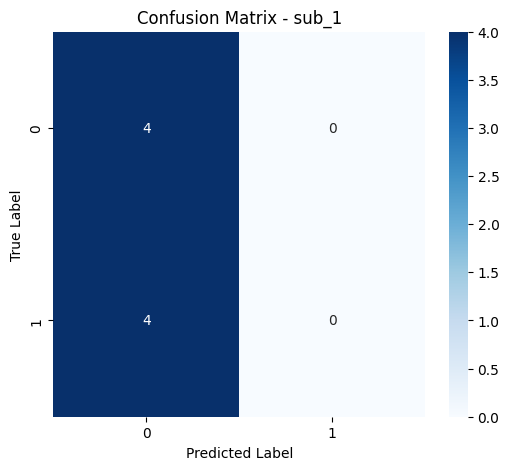

sub_2 ==> Precision: 0.375, Recall: 1.0, F1-score: 0.5454545454545454


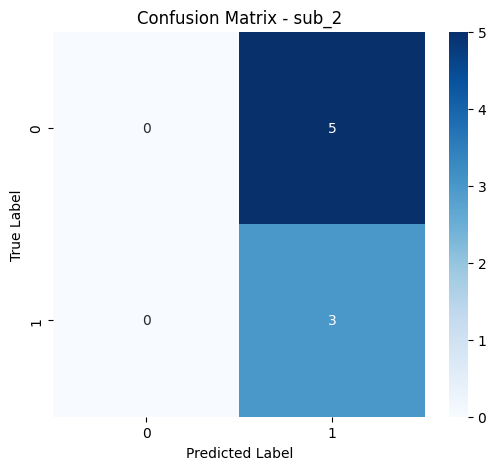

sub_3 ==> Precision: 0.0, Recall: 0.0, F1-score: 0.0


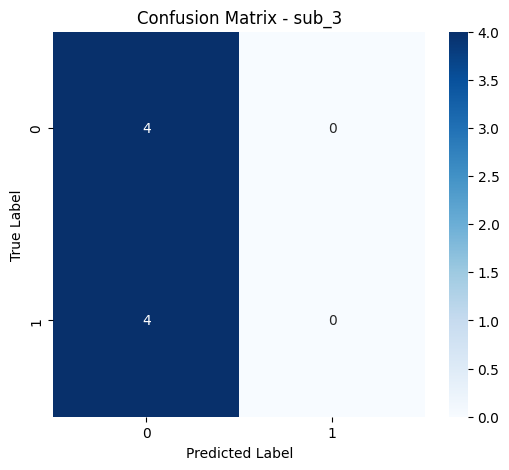

sub_4 ==> Precision: 0.25, Recall: 1.0, F1-score: 0.4


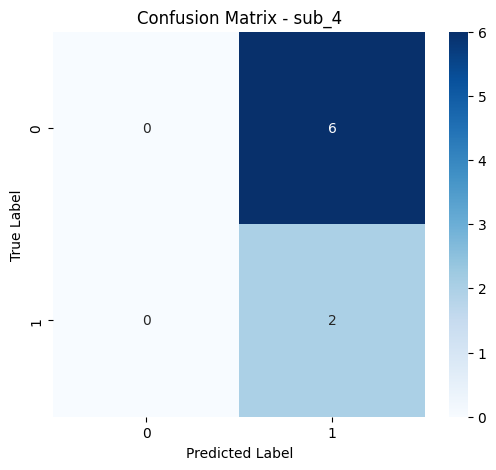

In [11]:
print(f"Baseline (Random guess): {1/num_classes}")
for sub_id in ["sub_1", "sub_2", "sub_3", "sub_4"]:
    f1 = results[sub_id]["f1"]
    precision = results[sub_id]["precision"]
    recall = results[sub_id]["recall"]
    print(f"{sub_id} ==> Precision: {precision}, Recall: {recall}, F1-score: {f1}")
    plot_cm(results[sub_id]["conf_mat"], sub_id)

## Modelling Task 2: Rock vs Paper vs Scisors

In [12]:
batch_size = 1
num_classes = 3

mode = "rps"
results = {}

for sub_id in sub_ids:
    print(f"============== {sub_id} ==============\n")
    # sample_window = min(min([val.shape[0] for val in cleaned_data[sub_id]["train"]["eeg"]]), min([val.shape[0] for val in cleaned_data[sub_id]["test"]["eeg"]]))
    
    print(f"sample_window = {sample_window}")
    train_set = Dataset(cleaned_data[sub_id]["train"], mode=mode, sample_window=sample_window)
    val_set = Dataset(cleaned_data[sub_id]["val"], mode=mode, sample_window=sample_window)
    test_set = Dataset(cleaned_data[sub_id]["test"], mode=mode, sample_window=sample_window)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=1, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=1, shuffle=False)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = EEGNet(num_electrodes=8, chunk_size=sample_window, num_classes=num_classes, kernel_1=8, kernel_2=8)
    model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        val_loss = 0
        correct = 0
        for steps, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
    
            optimizer.zero_grad()
            output = model(data.unsqueeze(1))
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        for steps, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
    
            output = model(data.unsqueeze(1))
            loss = criterion(output, target)
     
            val_loss += loss.item()

        scheduler.step(val_loss/len(val_loader))

        if (epoch+1) % 100 == 0: 
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")


    # evaluating
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data.unsqueeze(1))
            pred = output.argmax(dim=1, keepdim=True)
            gt = target.argmax(dim=1, keepdim=True)
            y_pred.append(pred.squeeze().cpu().detach().numpy())
            y_true.append(gt.squeeze().cpu().detach().numpy())
    
    precision = precision_score(y_true, y_pred, average='macro')  # Use 'macro' for multi-class
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='weighted')

    results[sub_id] = {
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "conf_mat": confusion_matrix(y_true, y_pred),
    }

============== sub_1 ==============

sample_window = 500
Epoch 100/1000, Loss: 0.5139, Val Loss: 1.1547
Epoch 200/1000, Loss: 0.4753, Val Loss: 1.2430
Epoch 300/1000, Loss: 0.4948, Val Loss: 1.1187
Epoch 400/1000, Loss: 0.5287, Val Loss: 1.1358
Epoch 500/1000, Loss: 0.5521, Val Loss: 1.1882
Epoch 600/1000, Loss: 0.5166, Val Loss: 1.1653
Epoch 700/1000, Loss: 0.4948, Val Loss: 1.2387
Epoch 800/1000, Loss: 0.5241, Val Loss: 1.2323
Epoch 900/1000, Loss: 0.5337, Val Loss: 1.2061
Epoch 1000/1000, Loss: 0.5610, Val Loss: 1.2090
============== sub_2 ==============

sample_window = 500


c:\Users\drago\anaconda3\envs\cogs_189\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.3973, Val Loss: 1.3210
Epoch 200/1000, Loss: 0.4738, Val Loss: 1.3550
Epoch 300/1000, Loss: 0.4346, Val Loss: 1.3069
Epoch 400/1000, Loss: 0.4477, Val Loss: 1.2791
Epoch 500/1000, Loss: 0.4470, Val Loss: 1.3228
Epoch 600/1000, Loss: 0.4172, Val Loss: 1.3178
Epoch 700/1000, Loss: 0.3721, Val Loss: 1.4361
Epoch 800/1000, Loss: 0.4330, Val Loss: 1.3696
Epoch 900/1000, Loss: 0.4019, Val Loss: 1.3170
Epoch 1000/1000, Loss: 0.3521, Val Loss: 1.3823
============== sub_3 ==============

sample_window = 500


c:\Users\drago\anaconda3\envs\cogs_189\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.5929, Val Loss: 1.2909
Epoch 200/1000, Loss: 0.6753, Val Loss: 1.2329
Epoch 300/1000, Loss: 0.5696, Val Loss: 1.2957
Epoch 400/1000, Loss: 0.6465, Val Loss: 1.2930
Epoch 500/1000, Loss: 0.6405, Val Loss: 1.2851
Epoch 600/1000, Loss: 0.6148, Val Loss: 1.3756
Epoch 700/1000, Loss: 0.5718, Val Loss: 1.3773
Epoch 800/1000, Loss: 0.6615, Val Loss: 1.2539
Epoch 900/1000, Loss: 0.5949, Val Loss: 1.2739
Epoch 1000/1000, Loss: 0.6018, Val Loss: 1.2635
============== sub_4 ==============

sample_window = 500


c:\Users\drago\anaconda3\envs\cogs_189\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.5953, Val Loss: 1.3910
Epoch 200/1000, Loss: 0.5260, Val Loss: 1.3135
Epoch 300/1000, Loss: 0.5695, Val Loss: 1.3526
Epoch 400/1000, Loss: 0.5728, Val Loss: 1.3921
Epoch 500/1000, Loss: 0.4389, Val Loss: 1.4384
Epoch 600/1000, Loss: 0.4652, Val Loss: 1.4559
Epoch 700/1000, Loss: 0.5552, Val Loss: 1.3989
Epoch 800/1000, Loss: 0.5740, Val Loss: 1.2138
Epoch 900/1000, Loss: 0.5553, Val Loss: 1.3260
Epoch 1000/1000, Loss: 0.5009, Val Loss: 1.3967
============== sub_5 ==============

sample_window = 500


c:\Users\drago\anaconda3\envs\cogs_189\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.5668, Val Loss: 1.4329
Epoch 200/1000, Loss: 0.5949, Val Loss: 1.4124
Epoch 300/1000, Loss: 0.5745, Val Loss: 1.5098
Epoch 400/1000, Loss: 0.5840, Val Loss: 1.3386
Epoch 500/1000, Loss: 0.5409, Val Loss: 1.4476
Epoch 600/1000, Loss: 0.5800, Val Loss: 1.4844
Epoch 700/1000, Loss: 0.5592, Val Loss: 1.4621
Epoch 800/1000, Loss: 0.5658, Val Loss: 1.4875
Epoch 900/1000, Loss: 0.4993, Val Loss: 1.4189
Epoch 1000/1000, Loss: 0.5226, Val Loss: 1.3976


c:\Users\drago\anaconda3\envs\cogs_189\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Baseline (Random guess): 0.3333333333333333
sub_1 ==> Precision: 0.09523809523809523, Recall: 0.2222222222222222, F1-score: 0.15000000000000002


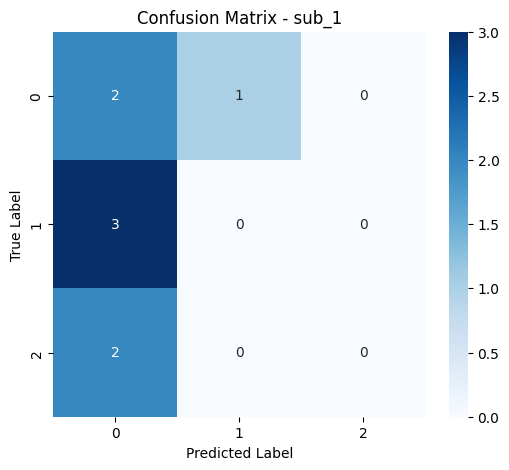

sub_2 ==> Precision: 0.08333333333333333, Recall: 0.3333333333333333, F1-score: 0.1


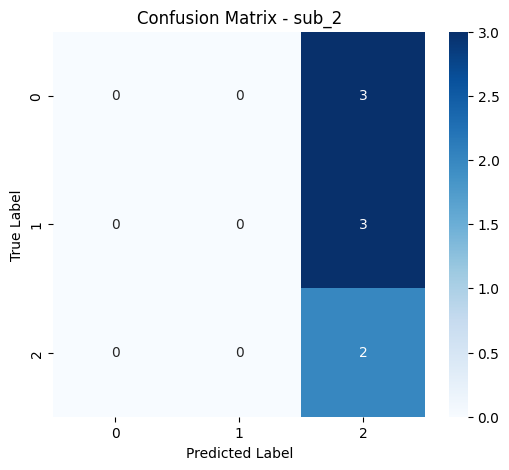

sub_3 ==> Precision: 0.16666666666666666, Recall: 0.2222222222222222, F1-score: 0.21428571428571427


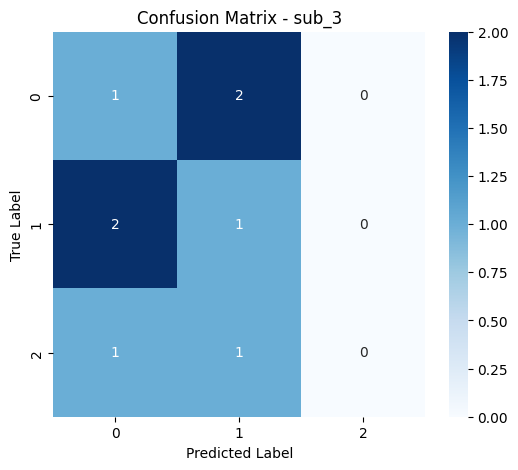

sub_4 ==> Precision: 0.047619047619047616, Recall: 0.16666666666666666, F1-score: 0.05555555555555555


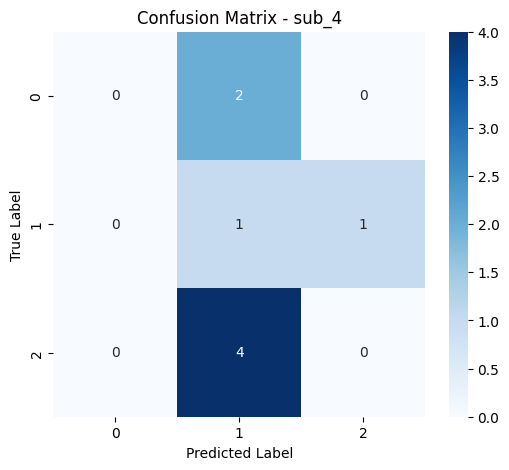

In [13]:
print(f"Baseline (Random guess): {1/num_classes}")
for sub_id in ["sub_1", "sub_2", "sub_3", "sub_4"]:
    f1 = results[sub_id]["f1"]
    precision = results[sub_id]["precision"]
    recall = results[sub_id]["recall"]
    print(f"{sub_id} ==> Precision: {precision}, Recall: {recall}, F1-score: {f1}")
    plot_cm(results[sub_id]["conf_mat"], sub_id)

## Modelling Task 3: Rock vs Paper vs Scisors

In [14]:
batch_size = 1
num_classes = 6

mode = "both"
results = {}

for sub_id in sub_ids:
    print(f"============== {sub_id} ==============\n")
    # sample_window = min(min([val.shape[0] for val in cleaned_data[sub_id]["train"]["eeg"]]), min([val.shape[0] for val in cleaned_data[sub_id]["test"]["eeg"]]))
    
    print(f"sample_window = {sample_window}")
    train_set = Dataset(cleaned_data[sub_id]["train"], mode=mode, sample_window=sample_window)
    val_set = Dataset(cleaned_data[sub_id]["val"], mode=mode, sample_window=sample_window)
    test_set = Dataset(cleaned_data[sub_id]["test"], mode=mode, sample_window=sample_window)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=1, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=1, shuffle=False)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = EEGNet(num_electrodes=8, chunk_size=sample_window, num_classes=num_classes, kernel_1=8, kernel_2=8)
    model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        val_loss = 0
        correct = 0
        for steps, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
    
            optimizer.zero_grad()
            output = model(data.unsqueeze(1))
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        for steps, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
    
            output = model(data.unsqueeze(1))
            loss = criterion(output, target)
     
            val_loss += loss.item()

        scheduler.step(val_loss/len(val_loader))

        if (epoch+1) % 100 == 0: 
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")


    # evaluating
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data.unsqueeze(1))
            pred = output.argmax(dim=1, keepdim=True)
            gt = target.argmax(dim=1, keepdim=True)
            y_pred.append(pred.squeeze().cpu().detach().numpy())
            y_true.append(gt.squeeze().cpu().detach().numpy())
    
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='weighted')

    results[sub_id] = {
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "conf_mat": confusion_matrix(y_true, y_pred),
    }

============== sub_1 ==============

sample_window = 500
Epoch 100/1000, Loss: 0.5948, Val Loss: 2.1324
Epoch 200/1000, Loss: 0.5391, Val Loss: 2.1398
Epoch 300/1000, Loss: 0.5137, Val Loss: 2.1878
Epoch 400/1000, Loss: 0.5033, Val Loss: 2.3704
Epoch 500/1000, Loss: 0.5374, Val Loss: 2.2247
Epoch 600/1000, Loss: 0.5287, Val Loss: 2.1627
Epoch 700/1000, Loss: 0.5521, Val Loss: 2.4561
Epoch 800/1000, Loss: 0.5056, Val Loss: 2.2910
Epoch 900/1000, Loss: 0.5466, Val Loss: 2.3976
Epoch 1000/1000, Loss: 0.5928, Val Loss: 2.1041
============== sub_2 ==============

sample_window = 500


c:\Users\drago\anaconda3\envs\cogs_189\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.5754, Val Loss: 2.4604
Epoch 200/1000, Loss: 0.5455, Val Loss: 2.5049
Epoch 300/1000, Loss: 0.6566, Val Loss: 2.5635
Epoch 400/1000, Loss: 0.6089, Val Loss: 2.5763
Epoch 500/1000, Loss: 0.5574, Val Loss: 2.6849
Epoch 600/1000, Loss: 0.6290, Val Loss: 2.4659
Epoch 700/1000, Loss: 0.5199, Val Loss: 2.4511
Epoch 800/1000, Loss: 0.5827, Val Loss: 2.6090
Epoch 900/1000, Loss: 0.6234, Val Loss: 2.3124
Epoch 1000/1000, Loss: 0.5629, Val Loss: 2.2818
============== sub_3 ==============

sample_window = 500


c:\Users\drago\anaconda3\envs\cogs_189\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.8374, Val Loss: 2.2932
Epoch 200/1000, Loss: 0.7995, Val Loss: 2.2592
Epoch 300/1000, Loss: 0.7147, Val Loss: 2.2117
Epoch 400/1000, Loss: 0.8699, Val Loss: 2.4069
Epoch 500/1000, Loss: 0.7288, Val Loss: 2.2829
Epoch 600/1000, Loss: 0.7778, Val Loss: 2.3160
Epoch 700/1000, Loss: 0.7320, Val Loss: 2.3363
Epoch 800/1000, Loss: 0.8016, Val Loss: 2.2870
Epoch 900/1000, Loss: 0.7878, Val Loss: 2.4501
Epoch 1000/1000, Loss: 0.8697, Val Loss: 2.2710
============== sub_4 ==============

sample_window = 500


c:\Users\drago\anaconda3\envs\cogs_189\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 1.0236, Val Loss: 2.2127
Epoch 200/1000, Loss: 1.0065, Val Loss: 2.1723
Epoch 300/1000, Loss: 0.9689, Val Loss: 2.2491
Epoch 400/1000, Loss: 1.0368, Val Loss: 2.1406
Epoch 500/1000, Loss: 0.9910, Val Loss: 2.2399
Epoch 600/1000, Loss: 1.0370, Val Loss: 2.2580
Epoch 700/1000, Loss: 1.0008, Val Loss: 2.2417
Epoch 800/1000, Loss: 1.0173, Val Loss: 2.1673
Epoch 900/1000, Loss: 0.9998, Val Loss: 2.1554
Epoch 1000/1000, Loss: 1.0414, Val Loss: 2.1785
============== sub_5 ==============

sample_window = 500


c:\Users\drago\anaconda3\envs\cogs_189\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\drago\anaconda3\envs\cogs_189\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.9167, Val Loss: 2.2047
Epoch 200/1000, Loss: 0.8956, Val Loss: 2.3084
Epoch 300/1000, Loss: 0.9599, Val Loss: 2.2332
Epoch 400/1000, Loss: 0.9049, Val Loss: 2.2966
Epoch 500/1000, Loss: 0.9301, Val Loss: 2.0945
Epoch 600/1000, Loss: 0.9517, Val Loss: 2.1375
Epoch 700/1000, Loss: 0.9053, Val Loss: 2.3311
Epoch 800/1000, Loss: 0.9339, Val Loss: 2.1803
Epoch 900/1000, Loss: 0.9829, Val Loss: 2.3228
Epoch 1000/1000, Loss: 0.8954, Val Loss: 2.0725


c:\Users\drago\anaconda3\envs\cogs_189\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\drago\anaconda3\envs\cogs_189\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Baseline (Random guess): 0.16666666666666666
sub_1 ==> Precision: 0.04, Recall: 0.1, F1-score: 0.07142857142857142


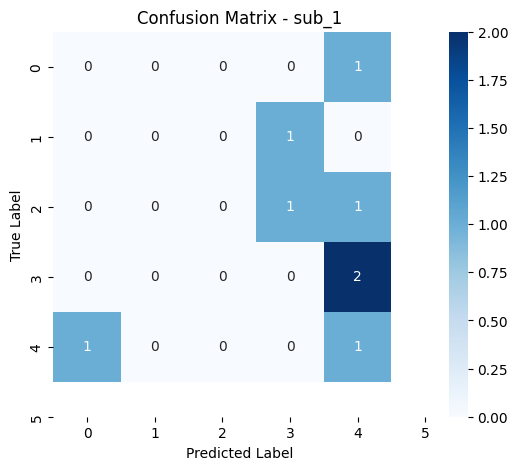

sub_2 ==> Precision: 0.020833333333333332, Recall: 0.16666666666666666, F1-score: 0.027777777777777776


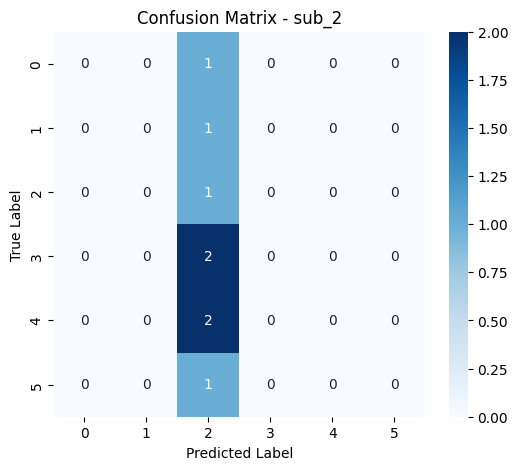

sub_3 ==> Precision: 0.05714285714285714, Recall: 0.2, F1-score: 0.1111111111111111


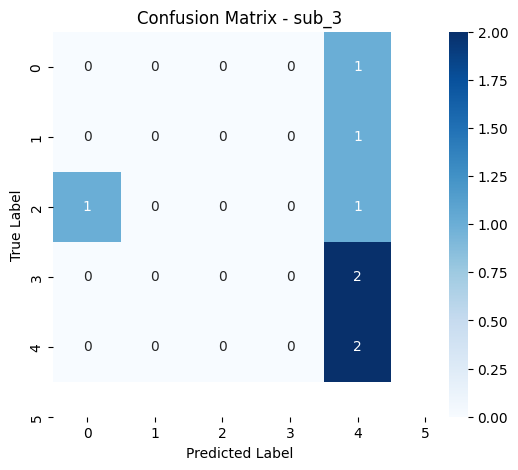

sub_4 ==> Precision: 0.0, Recall: 0.0, F1-score: 0.0


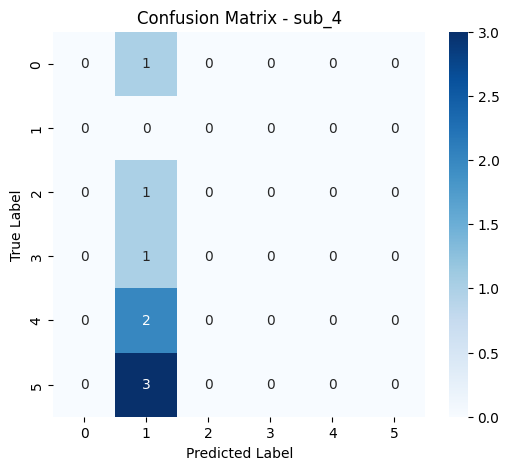

In [15]:
print(f"Baseline (Random guess): {1/num_classes}")
for sub_id in ["sub_1", "sub_2", "sub_3", "sub_4"]:
    f1 = results[sub_id]["f1"]
    precision = results[sub_id]["precision"]
    recall = results[sub_id]["recall"]
    print(f"{sub_id} ==> Precision: {precision}, Recall: {recall}, F1-score: {f1}")
    plot_cm(results[sub_id]["conf_mat"], sub_id)